# Naive Bayes Classifier for IRIS Dataset\n\nThis notebook implements comprehensive training and evaluation.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Load Dataset

In [3]:
df = pd.read_csv('../models/cleaned_iris_dataset.csv')
X = df.drop('species', axis=1)
y = df['species']
print(f'Dataset Shape: {df.shape}')
print(f'Features: {list(X.columns)}')
print(f'Classes: {sorted(y.unique())}')

Dataset Shape: (149, 5)
Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Classes: [0, 1, 2]


## 2. Train-Test Split & Scaling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f'Training set: {X_train.shape[0]} samples')
print(f'Testing set: {X_test.shape[0]} samples')

Training set: 119 samples
Testing set: 30 samples


## 3. Model Training with Hyperparameter Tuning

In [5]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

# Test all three variants
print("Testing Naive Bayes variants...")

# Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
gnb_score = gnb.score(X_test_scaled, y_test)
print(f'Gaussian NB accuracy: {gnb_score:.4f}')

# Bernoulli Naive Bayes
bnb = BernoulliNB()
bnb.fit(X_train_scaled, y_train)
bnb_score = bnb.score(X_test_scaled, y_test)
print(f'Bernoulli NB accuracy: {bnb_score:.4f}')

# Multinomial Naive Bayes (requires non-negative features)
X_train_pos = X_train_scaled - X_train_scaled.min() + 0.01
X_test_pos = X_test_scaled - X_test_scaled.min() + 0.01
mnb = MultinomialNB()
mnb.fit(X_train_pos, y_train)
mnb_score = mnb.score(X_test_pos, y_test)
print(f'Multinomial NB accuracy: {mnb_score:.4f}')

# Select best model
best_scores = {'Gaussian': gnb_score, 'Bernoulli': bnb_score, 'Multinomial': mnb_score}
best_variant = max(best_scores, key=best_scores.get)
print(f'\nBest variant: {best_variant} NB with accuracy: {best_scores[best_variant]:.4f}')

# Use Gaussian NB for final model (typically best for continuous features)
nb_best = gnb

# Hyperparameter tuning for Gaussian NB
param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)
nb_best = grid_search.best_estimator_
print(f'\nBest parameters: {grid_search.best_params_}')
print(f'Best CV score: {grid_search.best_score_:.4f}')

Testing Naive Bayes variants...
Gaussian NB accuracy: 0.9333
Bernoulli NB accuracy: 0.8000
Multinomial NB accuracy: 0.6333

Best variant: Gaussian NB with accuracy: 0.9333

Best parameters: {'var_smoothing': 0.0657933224657568}
Best CV score: 0.9580


## 4. Model Evaluation

Test Accuracy: 0.9333
\nClassification Report:
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       0.90      0.90      0.90        10
   Virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



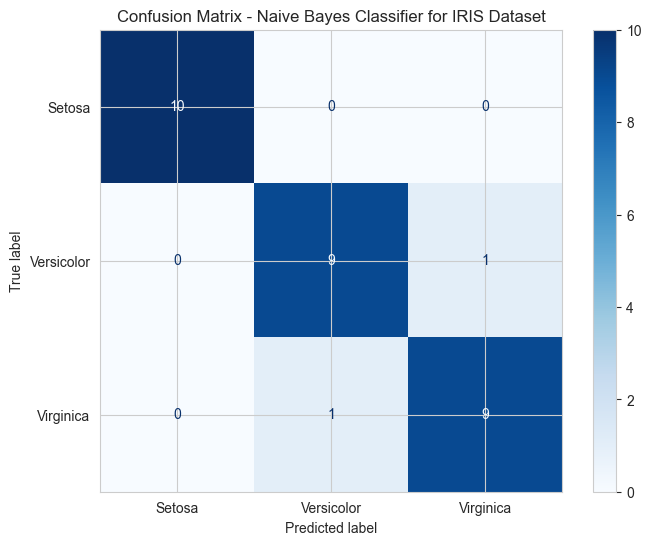

In [6]:
species_names = ['Setosa', 'Versicolor', 'Virginica']
y_test_pred = nb_best.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')
print('\\nClassification Report:')
print(classification_report(y_test, y_test_pred, target_names=species_names))
cm = confusion_matrix(y_test, y_test_pred)
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix - Naive Bayes Classifier for IRIS Dataset')
plt.show()

## 5. Model Inference

In [7]:
new_samples = np.array([[5.1, 3.5, 1.4, 0.2], [6.2, 2.9, 4.3, 1.3], [7.3, 2.9, 6.3, 1.8]])
new_samples_scaled = scaler.transform(new_samples)
predictions = nb_best.predict(new_samples_scaled)
probabilities = nb_best.predict_proba(new_samples_scaled)
for i, (sample, pred, proba) in enumerate(zip(new_samples, predictions, probabilities)):
    print(f'Sample {i+1}: {sample} -> {species_names[pred]} (confidence: {proba[pred]:.4f})')

Sample 1: [5.1 3.5 1.4 0.2] -> Setosa (confidence: 1.0000)
Sample 2: [6.2 2.9 4.3 1.3] -> Versicolor (confidence: 0.9926)
Sample 3: [7.3 2.9 6.3 1.8] -> Virginica (confidence: 0.9997)


## 6. Save Model

In [8]:
model_data = {'model': nb_best,
             'scaler': scaler,
              'feature_names': list(X.columns),
               'class_names': species_names, 
               'test_accuracy': test_accuracy}
with open('../models/naive_bayes_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)
print('✓ Model saved to ../models/naive_bayes_model.pkl')

✓ Model saved to ../models/naive_bayes_model.pkl
